# Assignment 4

**Anselmo Raffaele**

Matricola **846842**

r.anselmo@campus.unimib.it

### Import librerie

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, MaxPooling2D
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib as mpl
import os
import cv2

In [3]:
import json
from IPython.display import Image, display

### Definizione funzione per visualizzare le performance

In [4]:
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 
             color=colors[0],
             label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.2,1])
    else:
      plt.ylim([0,1])

    plt.legend()

### Dataset Load

https://www.kaggle.com/slothkong/10-monkey-species

In [5]:
base_path = '/Users/raffaeleanselmo/Desktop/10-monkey-species/'

(394, 700, 3)


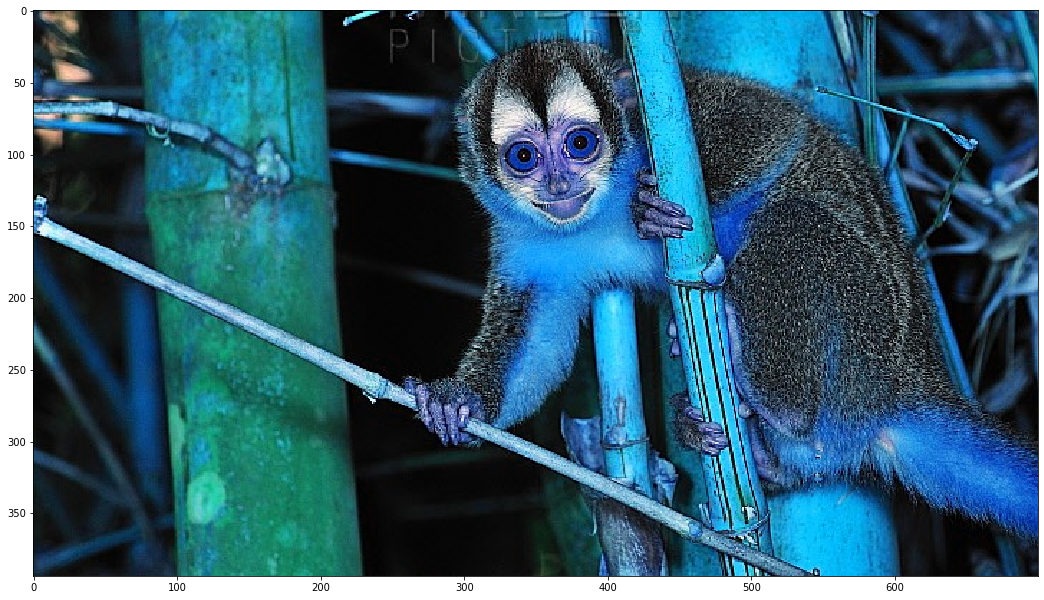

In [6]:
im1 = cv2.imread(base_path+'training/n8/n8119.jpg')
print(im1.shape)
plt.imshow(im1)

(660, 440, 3)


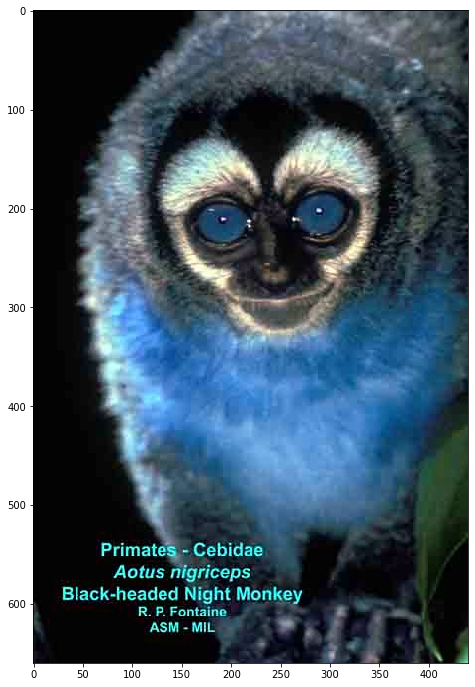

In [7]:
im2 = cv2.imread(base_path+'training/n8/n8118.jpg')
print(im2.shape)
plt.imshow(im2)

Il dataset contiene quasi 1400 immagini di dimensione variabile (min 400x300 px). Vengono perciò riportate tutte alla dimensione 224x224

In [8]:
train = [os.path.join(base_path+'/training',img) for img in os.listdir(base_path)]
test = [os.path.join(base_path+'/validation',img) for img in os.listdir(base_path)]

## Preprocessing

### Data Augmentation and validation set creation

In [9]:
batch_size = 32

In [10]:
#Training Set data Augmentation
data_processing = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                     horizontal_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     validation_split=0.2)
train_generator = data_processing.flow_from_directory(
        directory=base_path+'training',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        seed=1,
        subset='training'
)

Found 881 images belonging to 10 classes.


In [11]:
#Validation Set data Augmentation
val_generator = data_processing.flow_from_directory(
        directory=base_path+'training',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        seed=1,
        subset='validation'
)

Found 217 images belonging to 10 classes.


In [12]:
#Test Set data generation
test_processing = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_processing.flow_from_directory(
        directory=base_path+'validation',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
)

Found 272 images belonging to 10 classes.


## VGG16 Model Load

In [13]:
#Modello di base
base_net = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [14]:
#Creazione di un dizionario che mappi i layer ai loro nomi
layer_dict = dict([(layer.name, layer) for layer in base_net.layers])

In [15]:
#Visualizzazione tabellare
base_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

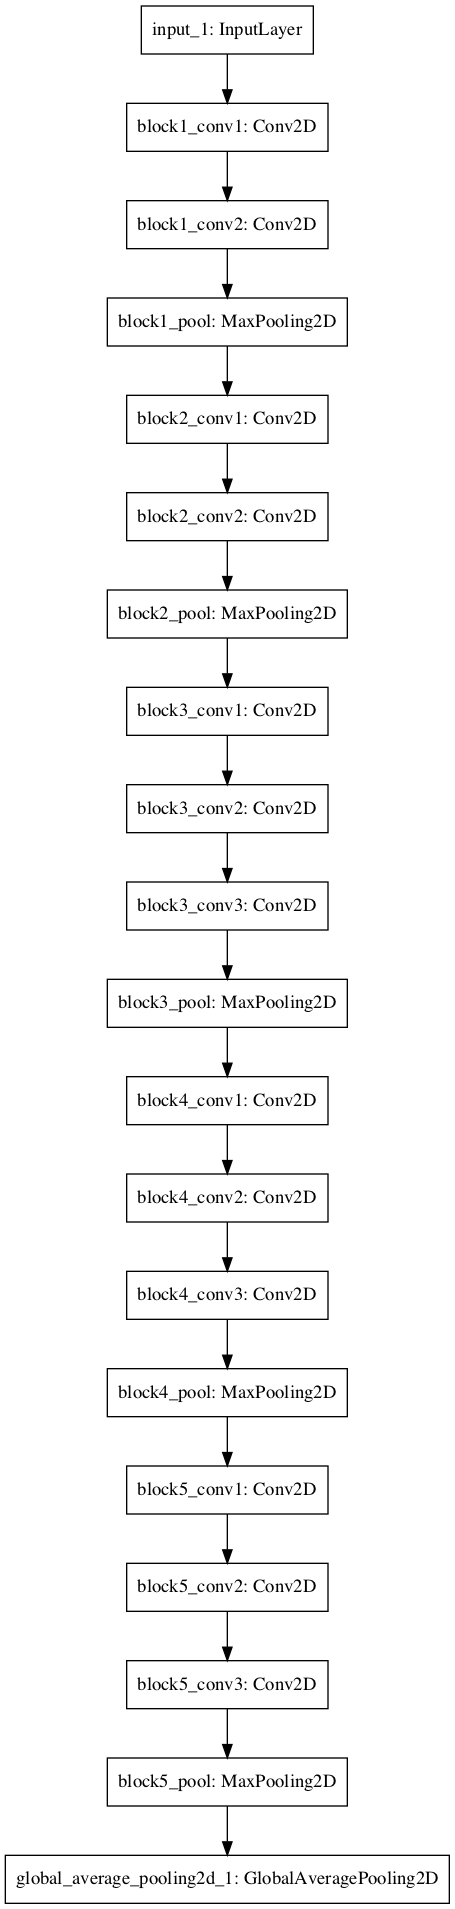

In [16]:
#Visualizzazione grafica
from keras.utils import plot_model
plot_model(base_net, to_file='model.png')

In [17]:
#Congelamento del modello di base
for layer in base_net.layers:
    layer.trainable = False

### Modello 1

In [18]:
#Output del modello di base
x = base_net.output
#Nuovo livello fully-connected intermedio + ReLU
x = Dense(512, activation='relu')(x)
#Nuovo livello di Dropout
x = Dropout(0.2)(x)
#Nuovo livello fully-connected finale + softmax
pred = Dense(10, activation='softmax')(x)

In [19]:
#Modello specializzato
net = Model(inputs=base_net.input, outputs=pred)

In [20]:
net.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [21]:
#Compilazione del modello per l'addestramento
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [22]:
epochs = 10
steps_per_epoch = 10

In [23]:
history = net.fit_generator(train_generator, 
                            epochs=epochs,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=val_generator)

Epoch 1/10
10/10 [==============================] - 66s 7s/step - loss: 8.5063 - accuracy: 0.4000 - val_loss: 0.2815 - val_accuracy: 0.7926
Epoch 2/10
10/10 [==============================] - 68s 7s/step - loss: 1.2640 - accuracy: 0.7406 - val_loss: 1.0797 - val_accuracy: 0.7604
Epoch 3/10
10/10 [==============================] - 67s 7s/step - loss: 0.6576 - accuracy: 0.8393 - val_loss: 0.3293 - val_accuracy: 0.8756
Epoch 4/10
10/10 [==============================] - 69s 7s/step - loss: 0.4767 - accuracy: 0.8820 - val_loss: 0.7019 - val_accuracy: 0.8525
Epoch 5/10
10/10 [==============================] - 71s 7s/step - loss: 0.3731 - accuracy: 0.9062 - val_loss: 0.5037 - val_accuracy: 0.8387
Epoch 6/10
10/10 [==============================] - 71s 7s/step - loss: 0.3424 - accuracy: 0.9125 - val_loss: 0.1671 - val_accuracy: 0.9401
Epoch 7/10
10/10 [==============================] - 69s 7s/step - loss: 0.4308 - accuracy: 0.9016 - val_loss: 0.4769 - val_accuracy: 0.9355
Epoch 8/10
10/10 [==

In [45]:
results = net.evaluate_generator(test_generator)
results

[0.0003255555348005146, 0.9595588445663452]

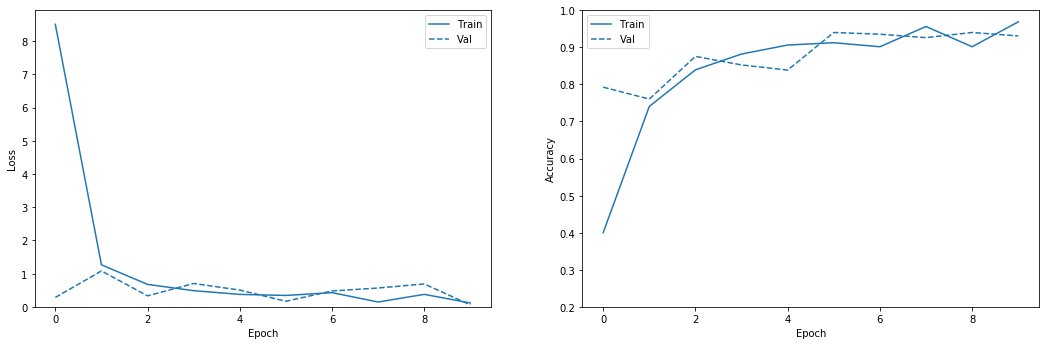

In [25]:
plot_metrics(history)

### Visual Investigation

In [26]:
#Caricamento di 4 foto di esempio da visualizzare insieme alla previsione
image_dir = base_path+'training'
img_paths = [os.path.join(image_dir, filename) for filename in 
               ['n0/n019.jpg',
                'n5/n5069.jpg',
                'n9/n915.jpg',
                'n2/n2113.jpg']]

In [27]:
#Definizione funzione per preparare le immagini al fitting della rete
image_size = 224
def read_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)

    return output

img_data = read_prep_images(img_paths)

In [28]:
#Previsione delle probabilità di appartenenza alle classi
preds = net.predict(img_data)

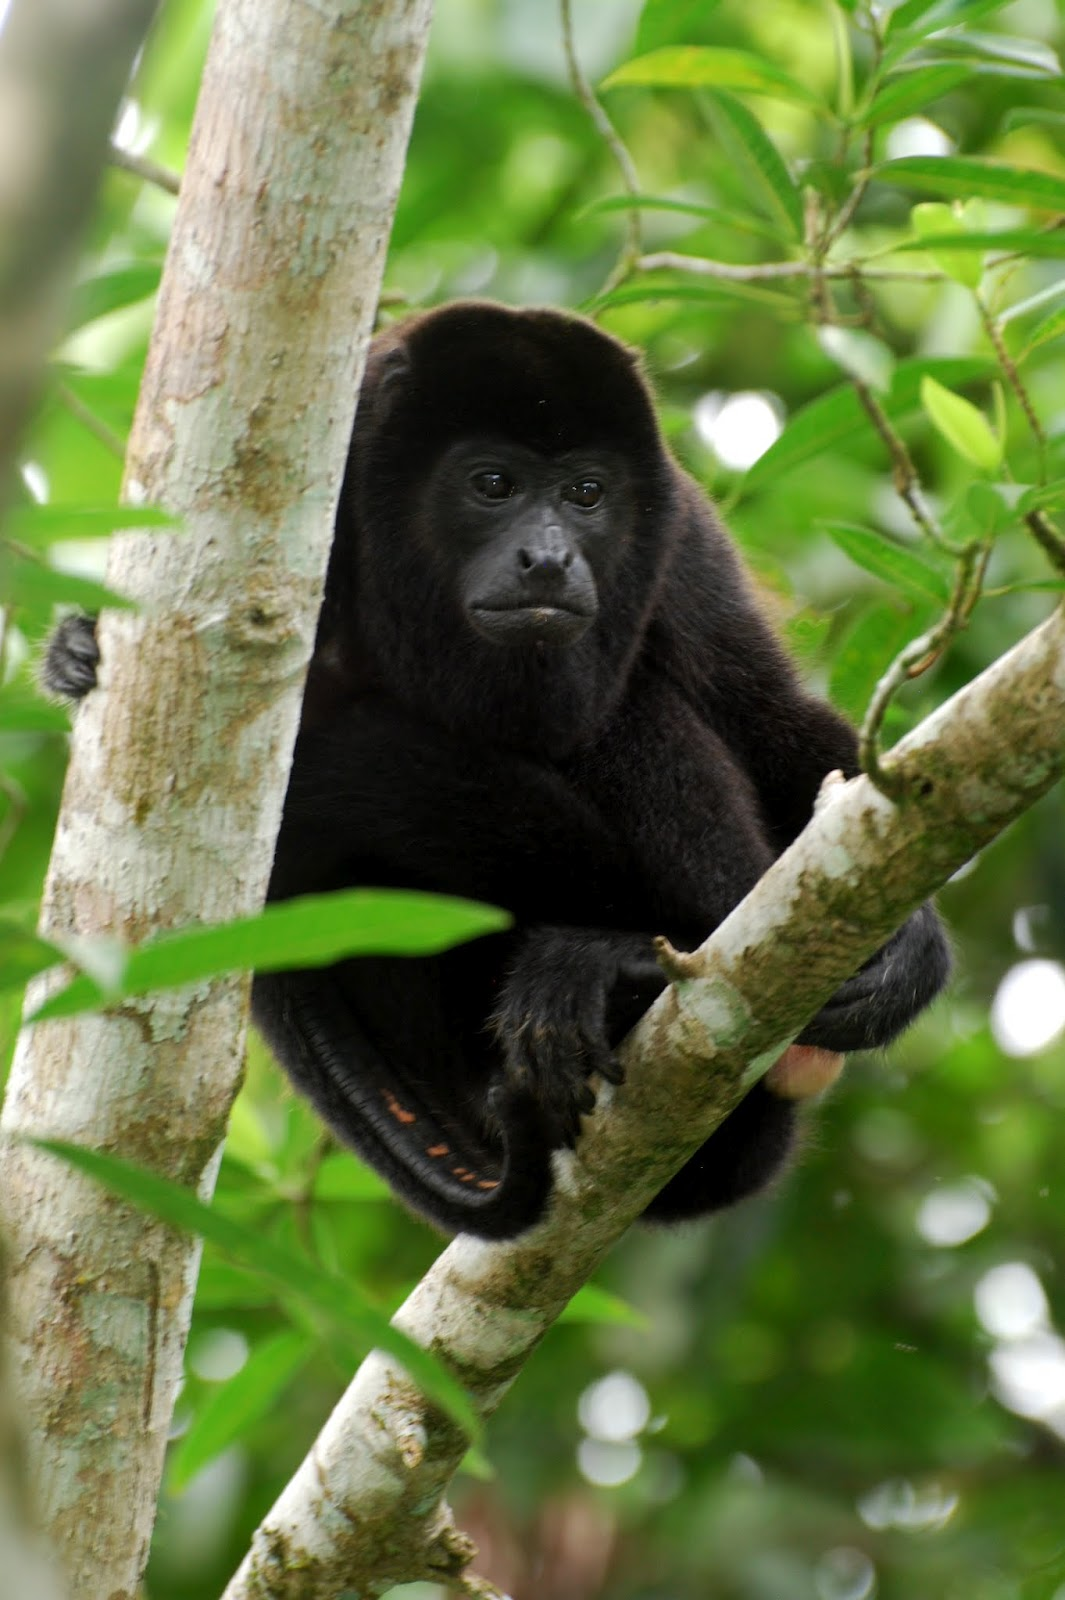

[('mantled_howler', 'n0', 1.0), ('black_headed_night_monkey', 'n8', 4.7283445e-12), ('japanese_macaque', 'n2', 8.5449383e-13), ('nilgiri_langur', 'n9', 2.6613239e-13), ('common_squirrel_monkey', 'n7', 1.2199103e-13)]
/Users/raffaeleanselmo/Desktop/10-monkey-species/training/n0/n019.jpg


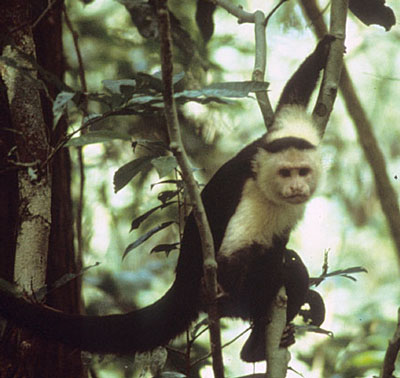

[('white_headed_capuchin', 'n5', 0.99993145), ('mantled_howler', 'n0', 6.5114386e-05), ('black_headed_night_monkey', 'n8', 2.9386952e-06), ('common_squirrel_monkey', 'n7', 3.929831e-07), ('nilgiri_langur', 'n9', 3.7565947e-08)]
/Users/raffaeleanselmo/Desktop/10-monkey-species/training/n5/n5069.jpg


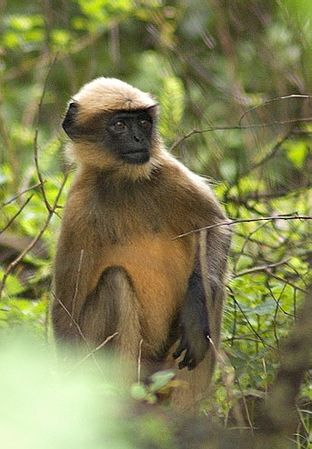

[('nilgiri_langur', 'n9', 0.9999628), ('bald_uakari', 'n1', 3.7225098e-05), ('white_headed_capuchin', 'n5', 1.2158354e-08), ('black_headed_night_monkey', 'n8', 7.0465203e-09), ('japanese_macaque', 'n2', 3.95743e-10)]
/Users/raffaeleanselmo/Desktop/10-monkey-species/training/n9/n915.jpg


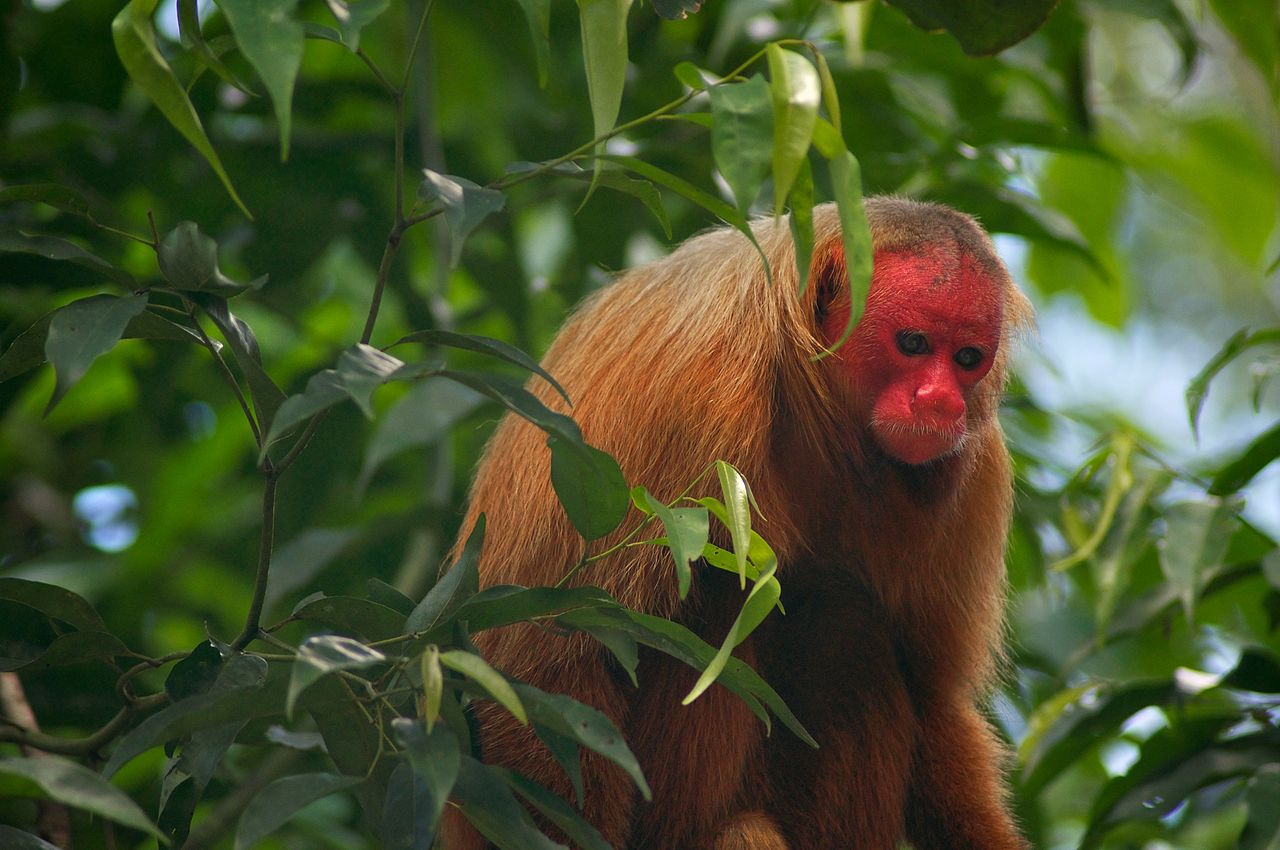

[('japanese_macaque', 'n2', 1.0), ('japanese_macaque', 'n3', 2.3508489e-11), ('black_headed_night_monkey', 'n8', 8.408792e-12), ('common_squirrel_monkey', 'n7', 4.546719e-12), ('pygmy_marmoset', 'n4', 3.4510138e-12)]
/Users/raffaeleanselmo/Desktop/10-monkey-species/training/n2/n2113.jpg


In [56]:
#Definizione della funzione per visualizzare le immagini e le probabilità di appartenenza alle 5 classi più probabili
#la classe reale è rappresentata dalla cartella di provenienza dell'immagine nella path
def decode_predictions(preds, top=5, class_list_path=None):
  index_list = json.load(open(class_list_path))
  results = []
  for pred in preds:
    top_indices = pred.argsort()[-top:][::-1]
    result = [tuple(index_list[str(i)]) + (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[2], reverse=True)
    results.append(result)
  return results


most_likely_labels = decode_predictions(preds, top=5, class_list_path=base_path+'class_monkey_species.json')
for i, img_path in enumerate(img_paths):
    display(Image(img_path))
    print(most_likely_labels[i])
    print(img_paths[i])

### Modello 2

In [30]:
#Output del quarto blocco di layer
x2 = layer_dict['block4_pool'].output
x2 = GlobalAveragePooling2D()(x2)
#Nuovo livello fully-connected intermedio + ReLU
x2 = Dense(512, activation='relu')(x2)
#Nuovo livello Dropout
x2 = Dropout(0.2)(x2)
#Nuovo livello fully-connected finale + softmax
pred2 = Dense(10, activation='softmax')(x2)

In [31]:
#Modello 2 specializzato
net2 = Model(inputs=base_net.input, outputs=pred2)

In [32]:
net2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [33]:
#Compilazione del modello per l'addestramento
net2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [34]:
history2 = net2.fit_generator(train_generator, 
                            epochs=epochs, 
                            steps_per_epoch=steps_per_epoch,  
                            validation_data=val_generator)

Epoch 1/10
10/10 [==============================] - 68s 7s/step - loss: 166.5257 - accuracy: 0.1531 - val_loss: 60.7141 - val_accuracy: 0.2488
Epoch 2/10
10/10 [==============================] - 65s 6s/step - loss: 63.5383 - accuracy: 0.2131 - val_loss: 31.9959 - val_accuracy: 0.2857
Epoch 3/10
10/10 [==============================] - 68s 7s/step - loss: 34.1598 - accuracy: 0.3031 - val_loss: 20.0874 - val_accuracy: 0.3825
Epoch 4/10
10/10 [==============================] - 66s 7s/step - loss: 27.6106 - accuracy: 0.3063 - val_loss: 28.7823 - val_accuracy: 0.3641
Epoch 5/10
10/10 [==============================] - 66s 7s/step - loss: 19.8126 - accuracy: 0.3836 - val_loss: 19.9600 - val_accuracy: 0.2949
Epoch 6/10
10/10 [==============================] - 69s 7s/step - loss: 10.1720 - accuracy: 0.3844 - val_loss: 7.2243 - val_accuracy: 0.4608
Epoch 7/10
10/10 [==============================] - 67s 7s/step - loss: 8.0240 - accuracy: 0.4295 - val_loss: 8.0823 - val_accuracy: 0.4332
Epoch 8/

In [48]:
results2 = net2.evaluate_generator(test_generator)
results2

[8.14851188659668, 0.34191176295280457]

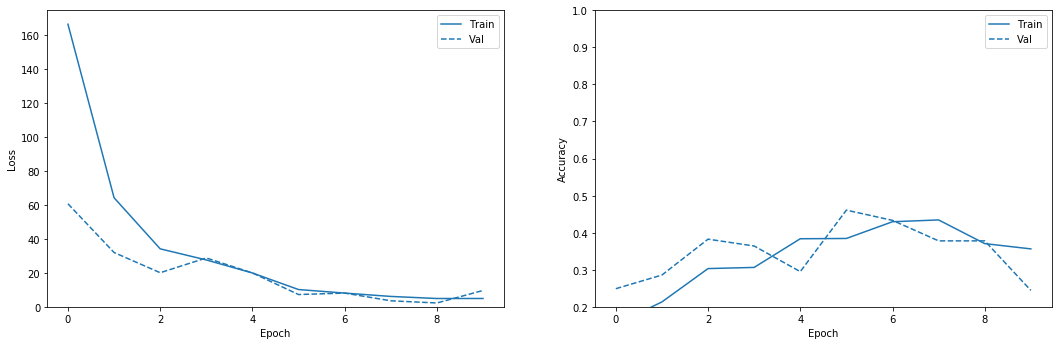

In [36]:
plot_metrics(history2)

### Modello 3

In [37]:
#Output del terzo blocco di layer
x3 = layer_dict['block3_pool'].output
x3 = GlobalAveragePooling2D()(x3)
#Nuovo livello fully-connected intermedio + ReLU
x3 = Dense(512, activation='relu')(x3)
#Nuovo livello Dropout
x3 = Dropout(0.2)(x3)
#Nuovo livello fully-connected finale + softmax
pred3 = Dense(10, activation='softmax')(x3)

In [38]:
#Modello 3 specializzato
net3 = Model(inputs=base_net.input, outputs=pred3)

In [39]:
net3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [40]:
#Compilazione del modello per l'addestramento
net3.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [41]:
history3 = net3.fit_generator(train_generator, 
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch, 
                              validation_data=val_generator)

Epoch 1/10
10/10 [==============================] - 52s 5s/step - loss: 842.9068 - accuracy: 0.1049 - val_loss: 449.8995 - val_accuracy: 0.1290
Epoch 2/10
10/10 [==============================] - 50s 5s/step - loss: 309.4707 - accuracy: 0.1656 - val_loss: 243.8768 - val_accuracy: 0.2396
Epoch 3/10
10/10 [==============================] - 50s 5s/step - loss: 271.1158 - accuracy: 0.1531 - val_loss: 143.8402 - val_accuracy: 0.1889
Epoch 4/10
10/10 [==============================] - 51s 5s/step - loss: 164.4015 - accuracy: 0.1969 - val_loss: 85.6760 - val_accuracy: 0.3733
Epoch 5/10
10/10 [==============================] - 48s 5s/step - loss: 124.9578 - accuracy: 0.2250 - val_loss: 92.6304 - val_accuracy: 0.1659
Epoch 6/10
10/10 [==============================] - 49s 5s/step - loss: 105.1144 - accuracy: 0.2262 - val_loss: 50.9993 - val_accuracy: 0.3272
Epoch 7/10
10/10 [==============================] - 47s 5s/step - loss: 75.0692 - accuracy: 0.2492 - val_loss: 24.8913 - val_accuracy: 0.31

In [47]:
results3 = net3.evaluate_generator(test_generator)
results3

[6.559032440185547, 0.28308823704719543]

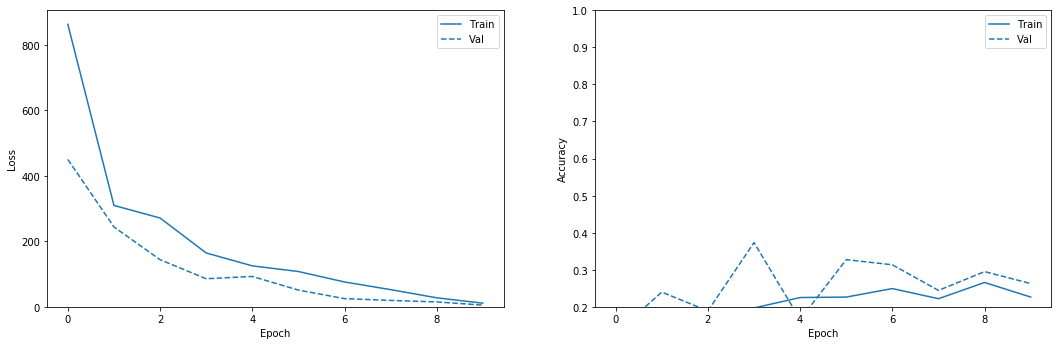

In [43]:
plot_metrics(history3)

### Models comparison on Test Set

In [49]:
print('Model 1')
print('Loss:', results[0], 'Accuracy:', results[1])
print('Model 2')
print('Loss:', results2[0], 'Accuracy:', results2[1])
print('Model 3')
print('Loss:', results3[0], 'Accuracy:', results3[1])

Model 1
Loss: 0.0003255555348005146 Accuracy: 0.9595588445663452
Model 2
Loss: 8.14851188659668 Accuracy: 0.34191176295280457
Model 3
Loss: 6.559032440185547 Accuracy: 0.28308823704719543
